(ch-jets)=

# The Jet Collection

```{warning}
Not all examples on this page have been updated to r22 and ServiceX 3. Examples that have not been updated will be marked using a similar warning. These examples will be updated soon.
```

We'll start with the Jet collection, one of the most commonly used collections in ATLAS. Below we'll look at:

* Getting jet kinematic properties like $p_T$ and $\eta$.
* Getting the constituents that went into building the jet.
* Getting the _attributes_ associated with the jet.

The data model used in ATLAS' xAOD is defined by the C++ objects. `func_adl` translates the python requests into C++ - so it needs to know about this data model. The `func_adl_servicex_xaodr22` package contains that information. For example, when we access a jet's $p_T$ with `j.pt()`, the `func_adl` system accesses meta-data in the `func_adl_servicex_xaodr22` to understand how to make the call, and that its return type is `double`. With few exceptions, that is how one accesses all methods on the xAOD objects.

The first thing to do is import what we need in our environment. This will be the case at the top of every chapter, but we show it for completness.

* Function from config file that returns dataset dictionary
* Various utilities for plotting and array manipulation
* Some helpers for accessing attributes below (`cpp_float, cpp_vfloat`)

In [2]:
from config import get_data
from config import sx_f
from func_adl_servicex_xaodr22 import FuncADLQueryPHYSLITE, cpp_float, cpp_vfloat

import matplotlib.pyplot as plt
import awkward as ak

To show how to use func_adl with xaod on the jet collection we will get $ p_{T} $ data above 30GeV. To do this we must build the query using func_adl and pass it to the get_dataset function. To do this we utilize func_adl Where() function and then select the resulting data using Select() where we also scale the data to GeV. We also select $ \eta $ and emf data for later in the tutorial.

In [3]:
query = FuncADLQueryPHYSLITE()
jets_per_event = (query
                    .Select(lambda e: e.Jets())
                    .Select(lambda jets: {
                            'pt': jets.Where(lambda j: (j.pt() / 1000 > 30)).Select(lambda j: j.pt() / 1000),
                            'eta': jets.Select(lambda j: j.eta()),
                            'phi': jets.Select(lambda j: j.phi()),
                        })
                 )

jet_data = get_data(jets_per_event,sx_f)

Output()

After getting the list of files that make up the dataset we need to loop over each file appending all the data into one array. To do this we get the data from each file in an Awkward array using uproot, then flatten it and append it to our data array. This data array can then be used to plot the results.

In [4]:
plt.hist(ak.flatten(jet_data.pt), bins=100, range=(0, 100))
plt.xlabel('Jet $p_T$ [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('Jet $p_T$ distribution')

NameError: name 'jet_data' is not defined

## Jet Constituents

```{warning}
This example has not been updated to r22 and ServiceX 3 yet.
```

Jets are composed of `TopoClusters` in ATLAS, and unfortunately, they are often skimmed away. They are not present, for example, in `DAOD_PHYS`, which is the skim being used here for most examples. To demonstrate their use we'll pull from a R21 EXOT15 skim that contains them. Since each jet has an array of topo clusters, and we are just interested in all the `TopoClusters`, we use two `SelectMany` calls to flatten both arrays.

In [4]:
topo_clusters = (ds_jz2_exot15
                    .SelectMany(lambda e: e.Jets())
                    .SelectMany(lambda j: j.getConstituents())
                    .Select(lambda tc: tc.pt())
                    .AsAwkwardArray('JetClusterPt')
                    .value()
                )

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

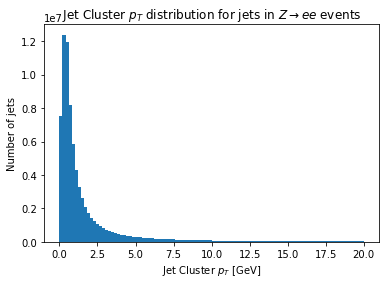

In [5]:
plt.hist(topo_clusters.JetClusterPt/1000.0, bins=100, range=(0, 20))
plt.xlabel('Jet Cluster $p_T$ [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('Jet Cluster $p_T$ distribution for jets in $Z\\rightarrow ee$ events')

## Jet Moments

Attributes are called _moments_ by the ATLAS Jet/ETMiss group. They are extra information that has been added into the jet object. The [Run 2 Moments Page](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/Run2JetMoments) lists all the moments. To access them you'll need to know the return type explicitly, and parameterize your call to `getAttribute` appropriately.

Here we grab the `EMFrac` moment, which is the EM Fraction of the jet. It is a single float for each jet. We specify the type with the `cpp_float` in the `getAttribute[cpp_float]('EMFrac')` call. This is translated into C++ that looks something like `j->getAttribute<float>("EMFrac")`.

In [3]:
query = FuncADLQueryPHYSLITE()
jets_per_event = (query
                  .Select(lambda e: e.Jets())
                  .Select(lambda jets: {
                        'emf': jets.Where(lambda j: (j.pt() / 1000) > 30).Select(lambda j: j.getAttribute[cpp_float]('EMFrac')),
                     })
                 )

moments_data = get_data(jets_per_event, sx_f)

Output()

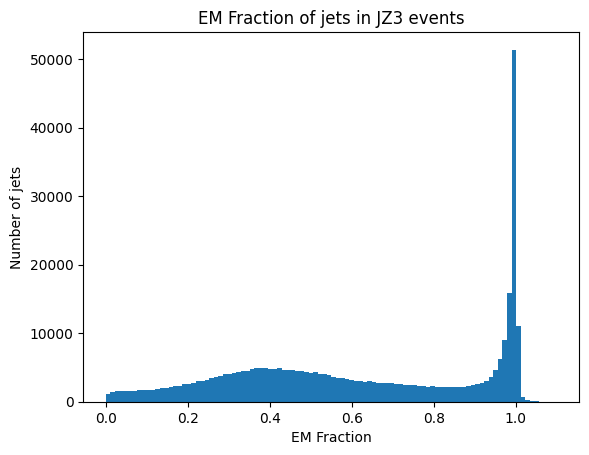

In [5]:
plt.hist(ak.flatten(moments_data.emf), bins=100, range=(0, 1.1))
plt.xlabel('EM Fraction')
plt.ylabel('Number of jets')
_ = plt.title('EM Fraction of jets in JZ3 events')

More complex objects can come back as well. For example, vectors of floats (`std::vector<float>`). Here is a sample with the sum track $p_T$ when track $p_T > 500$ MeV.

In [ ]:
query = FuncADLQueryPHYSLITE()
jets_per_event = (query
                  .Select(lambda e: e.Jets())
                  .Select(lambda jets: {
                        'sum_pt': jets.Select(lambda j: j.getAttribute[cpp_vfloat]('SumPtTrkPt500') / 1000)
                    })
                 )

moment_data = get_data(jets_per_event,sx_f)

Output()

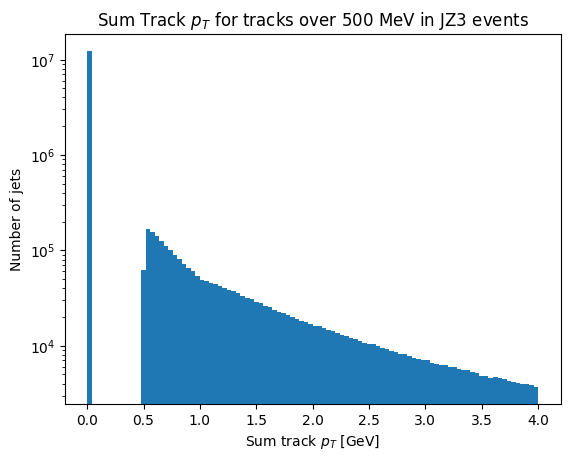

In [8]:
plt.hist(ak.flatten(ak.flatten(moment_data.sum_pt)), bins=100, range=(0, 4))
plt.xlabel('Sum track $p_T$ [GeV]')
plt.ylabel('Number of jets')
plt.yscale('log')
_ = plt.title('Sum Track $p_T$ for tracks over 500 MeV in JZ3 events')

As with everything else in the ATLAS data model, even if they are reconstructed and associated with the jet, they can be stripped out with slimming - so just because they are declared on the Run 2 Moments page, it doesn't mean they actually exist in the data file you are looking at.

This describes the basics of how to access jets in the ATLAS xAOD. The next chapter will continue discussing jets, focusing on how calibrations are handled by the `func_adl` backend.

## The Data Model

The data model when this documentation was last built was:

In [4]:
from func_adl_servicex_xaodr22.xAOD.jet_v1 import Jet_v1
help(Jet_v1)

Help on class Jet_v1 in module func_adl_servicex_xaodr22.xAOD.jet_v1:

class Jet_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  constituentLinks(self) -> 'func_adl_servicex_xaodr22.vector_elementlink_datavector_xaod_iparticle___.vector_ElementLink_DataVector_xAOD_IParticle___'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  getAlgorithmType(self) -> 'func_adl_servicex_xaodr22.xAOD.jetalgorithmtype.JetAlgorithmType.ID'
 |      A method
 |  
 |  getConstituents(self) -> 'func_adl_servicex_xaodr22.xAOD.jetconstituentvector.JetConstituentVector'
 |      A method
 |  
 |  getInputType(self) -> 'func_adl_servicex_xaodr22.xAOD.jetinput.JetInput.Type'
 |      A method
 |  
 |  getSizeParameter(self) -> 'float'
 |      A method
 |  
 |  hasNonConstStore(self) -> 'bool'
 |      A method
 |  
 |  hasStore(self) -> 'bool'
 |      A method
 |  
 |

In [25]:
from func_adl_servicex_xaodr22.xAOD.jetconstituent import JetConstituent
help(JetConstituent)

Help on class JetConstituent in module func_adl_servicex_xaodr22.xAOD.jetconstituent:

class JetConstituent(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  isSpacelike(self) -> 'bool'
 |      A method
 |  
 |  isTimelike(self) -> 'bool'
 |      A method
 |  
 |  m(self) -> 'float'
 |      A method
 |  
 |  phi(self) -> 'float'
 |      A method
 |  
 |  pt(self) -> 'float'
 |      A method
 |  
 |  rapidity(self) -> 'float'
 |      A method
 |  
 |  rawConstituent(self) -> 'func_adl_servicex_xaodr22.xAOD.iparticle.IParticle'
 |      A method
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Further Information

* The [`xAOD::Jet_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODJet/xAODJet/versions/Jet_v1.h) with all the inline documentation.
* The [`xAOD::JetConstituent` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODJet/xAODJet/JetConstituentVector.h) with all the inline documentation.
* The [Jet ET-Miss Recommendation Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/JetEtmissRecommendationsR21) on the ATLAS TWiki
* The [Run 2 Moments Page](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/Run2JetMoments)